# Color transfer with Optimal transport between GMM

This notebook illustrates the use of the distance $GW_2$ for color transfer, as described in

[Delon, Desolneux, *A Wasserstein-type distance in the space of Gaussian Mixture Models*, 2019.](https://hal.archives-ouvertes.fr/hal-02178204)

We start by importing the necessary libraries.



In [1]:
# author: Julie Delon <julie.delon 'at' paris 'dot' descartes 'dot' fr>

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as spl
import scipy.stats as sps 

import sklearn.mixture    # for EM
from sklearn.cluster import KMeans  # for kmeans

# Optimal Transport library https://github.com/rflamary/POT
import ot                 

We import the main functions used in this notebook. 

In [2]:
from gmmot import *

In [3]:
path = '../im/'

# Discrete Optimal Transport between Gaussian Mixtures

## Color transfer with GMM-OT

We read two color images into numpy arrays.
Be careful that jpg images must be cast to double and normalized to [0,1]. 

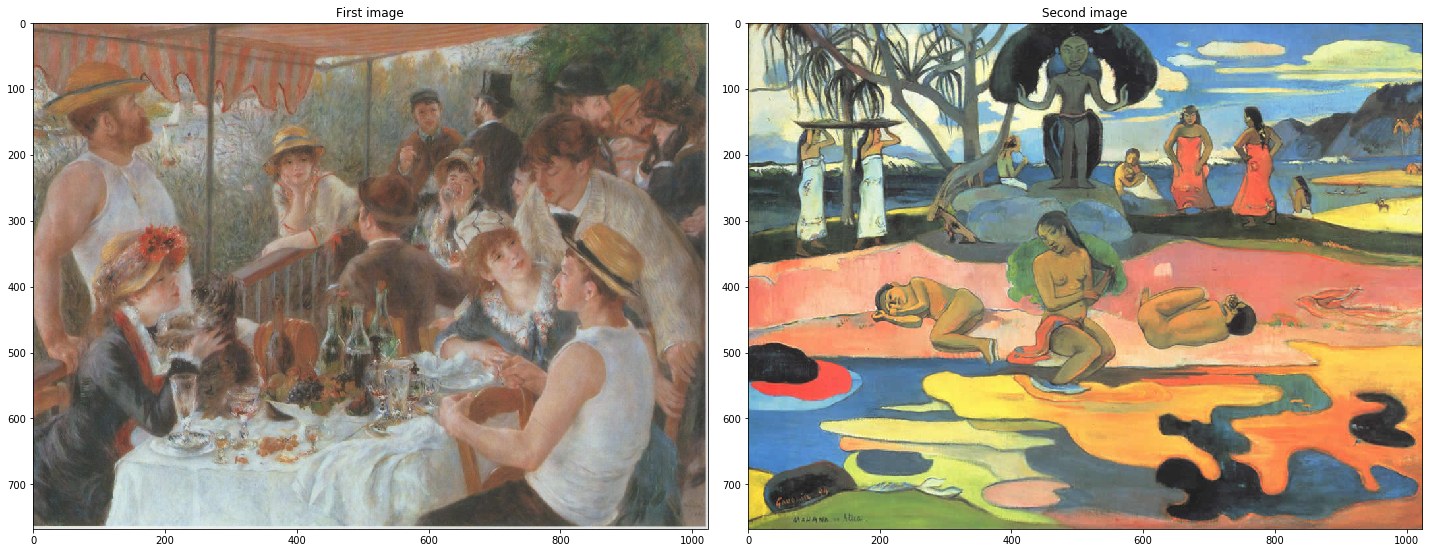

In [4]:
#ATTENTION : if images are of type jpg or bmp, they should be normalized to [0,1] 
u = plt.imread(path+'renoir.jpg')/255
v = plt.imread(path+'gauguin.jpg')/255
nru,ncu,nch = u.shape
nrv,ncv,nch = v.shape

# image display thanks to the function imshow of the pyplot library of matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

#we display the images
axes[0].imshow(u)
axes[0].set_title('First image')
axes[1].imshow(v)
axes[1].set_title('Second image')
fig.tight_layout()

We display their 3D color scatter plots.

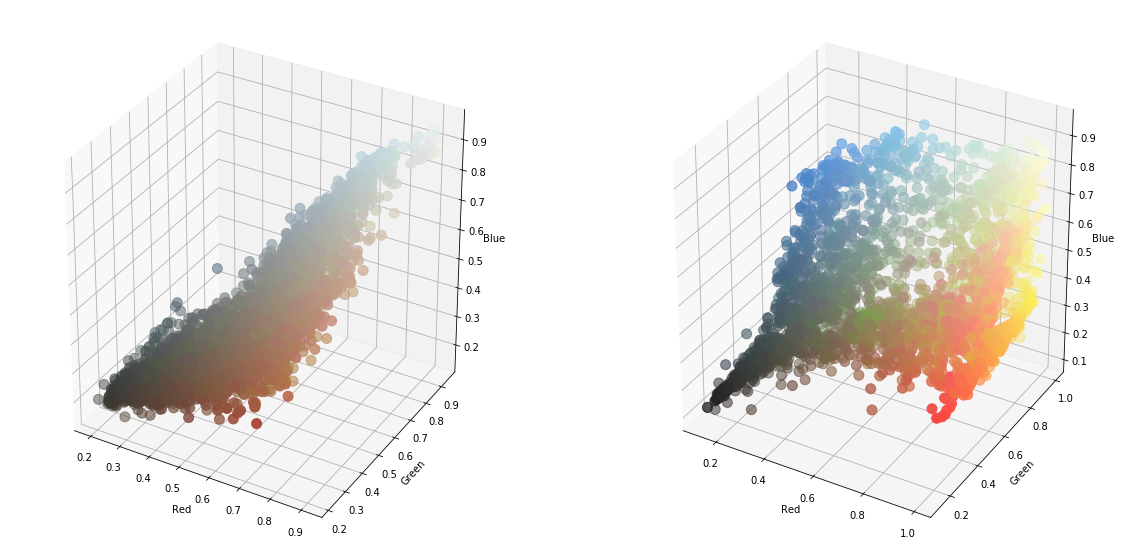

In [5]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=Xs,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");


### Separable optimal transport

First, we show the result of separable optimal transport (implemented here for two images of the same size).

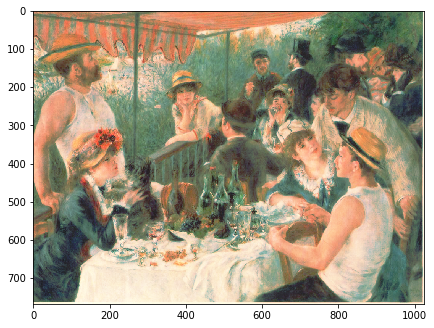

In [6]:
# BE CAREFUL: this implementation works only if u and v have the same size
uout = np.copy(u)

for k in range(3):
    uk = u[:,:,k]
    vk = v[:,:,k]   
    uk_sort,index_u=np.sort(uk,axis=None),np.argsort(uk,axis=None)
    vk_sort,index_v=np.sort(vk,axis=None),np.argsort(vk,axis=None)
    uspecifv= np.zeros(nru*ncu)
    uspecifv[index_u] = vk_sort
    uspecifv = uspecifv.reshape(nru,ncu)
    uout[:,:,k] = uspecifv

#Display images
plt.figure(figsize=(7, 7))
plt.imshow(uout)

### Estimating the GMM with scikit-learn 

We use scikit-learn to compute the GMM from the two color 3d point clouds.

In [7]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
k = 10 # number of classes
ninit = 1
K0,K1 = k,k
gmmX = sklearn.mixture.GaussianMixture(n_components=K0, covariance_type='full',n_init=ninit).fit(X) # spherical or full 
pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
ClassesX = gmmX.predict(X) 
ProbaClassesX = gmmX.predict_proba(X) 

gmmY = sklearn.mixture.GaussianMixture(n_components=K1, covariance_type='full',n_init=ninit).fit(Y)  # spherical or full 
pi1,mu1,S1 = gmmY.weights_, gmmY.means_, gmmY.covariances_ 
ClassesY = gmmY.predict(Y) 
ProbaClassesY = gmmY.predict_proba(Y)

We can display the following classes on the scatter plots.

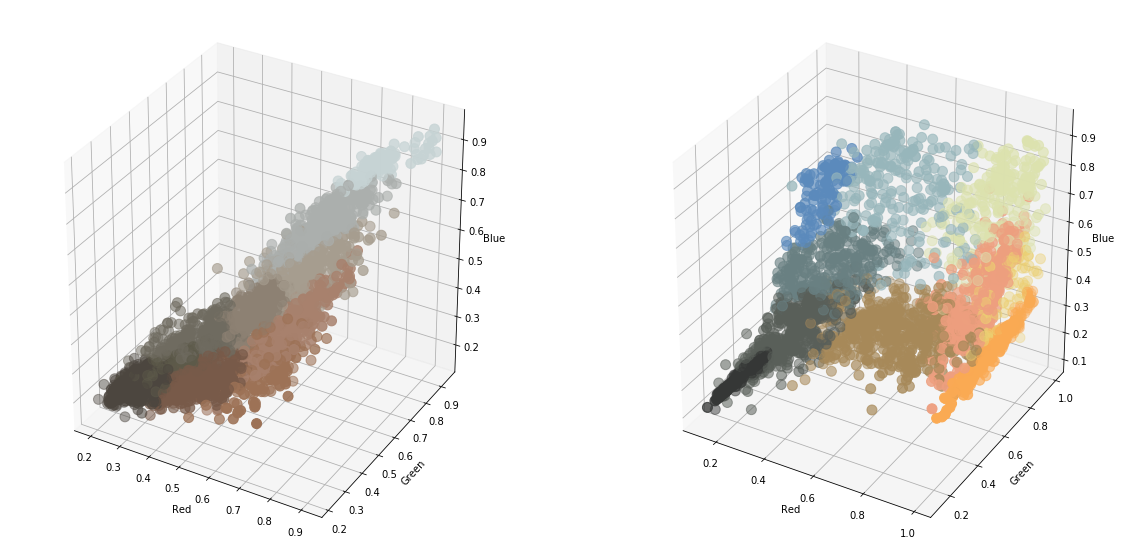

In [8]:
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]
ClassesXsubsample = ClassesX[idX]
ClassesYsubsample = ClassesY[idY]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=mu0[ClassesXsubsample,:],s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=mu1[ClassesYsubsample,:],s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

We can also display the segmentations of $u$ and $v$ provided by the GMM (the color of pixels of the same class is the mean of the class)

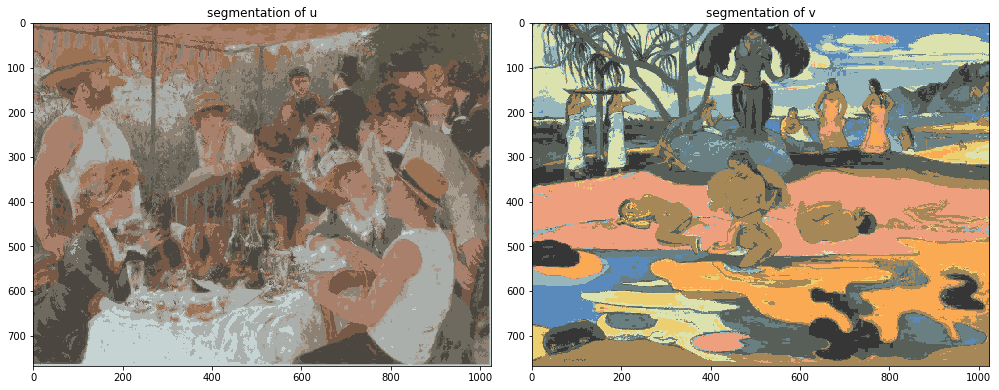

In [9]:
# display the corresponding image segmentations
useg = mu0[ClassesX]
useg = useg.reshape((nru,ncu,3))
vseg = mu1[ClassesY]
vseg = vseg.reshape((nrv,ncv,3))
# display
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].imshow(useg)
axes[0].set_title('segmentation of u')
axes[1].imshow(vseg)
axes[1].set_title('segmentation of v')
fig.tight_layout()

### Use GW2 for color transfer 

Then, we can use the GW2 transport map between these two GMM for color transfer.

In [10]:
# Compute the K0xK1 OT matrix between the members of the mixtures
wstar,dist = GW2(pi0/np.sum(pi0),pi1/np.sum(pi1),mu0,mu1,S0,S1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


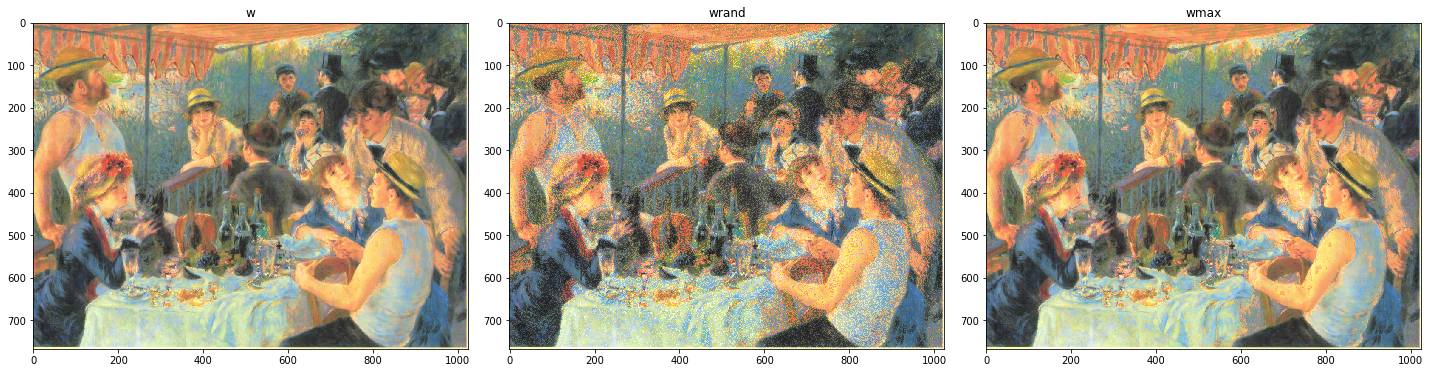

In [11]:
# Compute all Tkl maps at all points of u 
T = np.zeros((K0,K1,3,nru*ncu))
for k in range(K0):
        for l in range(K1):
            T[k,l,:,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:],X).T   
            
# Compute mean color transfer on all points
Tmeanx = np.zeros((3,nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmeanx += wstar[k,l]/pi0[k]*ProbaClassesX[:,k].T*T[k,l,:,:]
                
# Compute random color transfer on all points (random sample with posterior distribution)
Trandx = np.zeros((3,nru*ncu))
tmp = np.zeros((K0*K1,nru*ncu))
for k in range(K0):
    for l in range(K1):
        tmp[k+K0*l,:]= wstar[k,l]/pi0[k]*ProbaClassesX[:,k]
for i in range(nru*ncu):
    m = np.random.choice(K0*K1,p=tmp[:,i])
    l = m//K0
    k = m - K0*l
    Trandx[:,i] = T[k,l,:,i]        

    
# Compute best color transfer on all points (only best class for each point)
Tmaxx = np.zeros((3,nru*ncu))
normalisation = np.zeros((nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmaxx += wstar[k,l]*T[k,l,:,:]*(ClassesX==k).T
        normalisation +=wstar[k,l]*(ClassesX==k).T
Tmaxx = Tmaxx/normalisation


# Display result as an image
w=Tmeanx.T.reshape((nru,ncu,3))
wmax=Tmaxx.T.reshape((nru,ncu,3))
wrand=Trandx.T.reshape((nru,ncu,3))


#we display the images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axes[0].imshow(w)
axes[0].set_title('w')
axes[1].imshow(wrand)
axes[1].set_title('wrand')
axes[2].imshow(wmax)
axes[2].set_title('wmax')
fig.tight_layout()

# Result regularization (optionnal)

A common drawback of classical methods aiming at color and contrast modifications is the revealing of artefacts (JPEG blocs, color inconsistancies, noise enhancement) or the attenuation of details and textures (see for instance the following [web page](http://perso.telecom-paristech.fr/~delon/artefact_removal_html/)). 
Let $u$ be an image and $g(u)$ the same  image after color or contrast modification, we write $\mathcal{M}(u) = g(u) - u$. All artefacts observable in $g(u)$ can be seen as irregularities in these difference map $\mathcal{M}(u)$. In order to reduce these artefacts, we propose to filter this difference map thanks to an operator $Y_u$ and to reconstruct the image:

$$T(g(u)) = u + Y_u(g(u)-u).$$

We will use for $Y_u$ the guided filter described in the paper

[*Guided Image Filtering*, Kaiming He1, Jian Sun2, and Xiaoou Tang, ECCV 2010.](http://kaiminghe.com/publications/eccv10guidedfilter.pdf)


In [12]:
diff = w-u
out = np.zeros_like(u)

for i in range(3):
    out[:,:,i] = guided_filter(diff[:,:,i],u[:,:,i], 10,1e-4 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


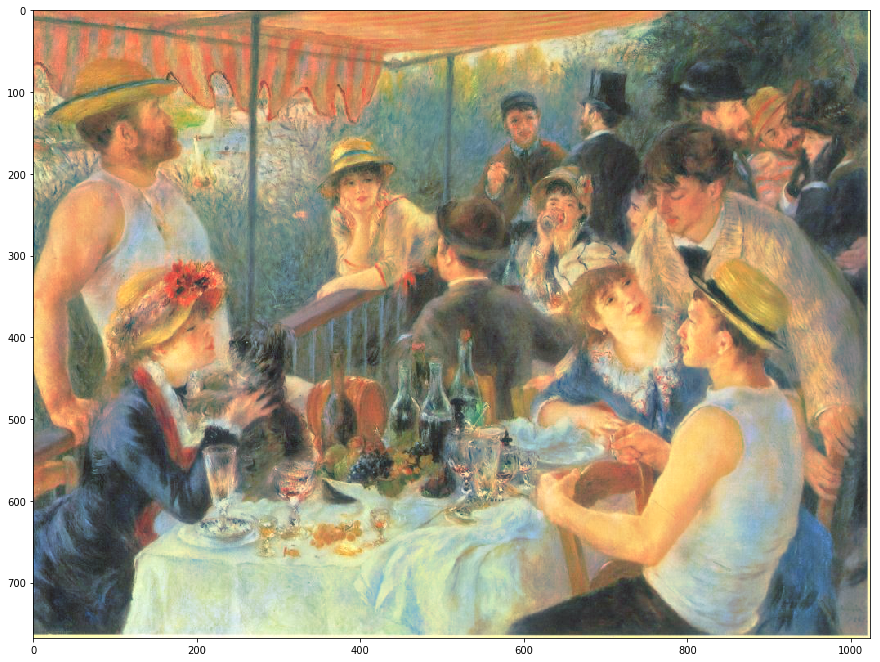

In [13]:
#we display the result
plt.figure(figsize=(15, 15))
plt.imshow(out+u)